In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from io import open
import os
import numpy as np
import time
import string

In [20]:
# MeCab is an open-source text segmentation library for use with text written in the Japanese.
import MeCab # pip install mecab-python3
wakati = MeCab.Tagger("-Owakati")

example = "春になれば花が咲き、夏にはほととぎすが鳴き、秋には月が美しく、冬には雪が降って身がひきしまる。".strip('。')
print(wakati.parse(example))

春 に なれ ば 花 が 咲き 、 夏 に は ほととぎす が 鳴き 、 秋 に は 月 が 美しく 、 冬 に は 雪 が 降っ て 身 が ひきしまる 



In [21]:
MAX_LEN_SENTENCE = 10
SOS = 0
EOS = 1

class Language:
    def __init__(self, name_lang):
        self.name = name_lang
        self.word2index = {}
        self.index2word = {SOS: "SOS", EOS: "EOS"}
        self.vocab_size = 2
        
    def __len__(self):
        return self.vocab_size
        
    def addWords(self, sentence):
        for word in sentence.split(' '):
            if word not in self.word2index:
                self.index2word[self.vocab_size] = word
                self.word2index[word] = self.vocab_size
                self.vocab_size += 1

In [22]:
class LanguageTranslate():
    def __init__(self, input_lang, target_lang, file_path='./dictionary', limit_size=None):
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.pair_sentences = []
        
        file_name = "{}-{}.txt".format(self.input_lang.name, self.target_lang.name)
        file_name = os.path.join(file_path, file_name)
        lines = open(file_name).read().strip().split('\n')
        
        self.pair_sentences = [[s for s in line.split('\t')[:2]] for line in lines]
        
        # if the language is japanese do text segmentation
        for s in self.pair_sentences:
            if self.target_lang.name == 'jpn':
                s[1] = wakati.parse(s[1]).strip(' \n')#.strip('\n')#.strip('。')
                s[1] = s[1].strip('。')
            else : s[1] = self._normalize(s[1])
            s[0] = self._normalize(s[0])
        
        for pairs in self.pair_sentences: 
            self.input_lang.addWords(pairs[0])
            self.target_lang.addWords(pairs[1])
        
        print('Pairs size (before filter):', len(self.pair_sentences))
        self.pair_sentences = self._filterpairs(self.pair_sentences, lang_1=self.input_lang.name) 
        print('Pairs size (after filter):', len(self.pair_sentences))
       
    def _filterpairs(self, pairs, lang_1='eng'):
        filter_prefixes = ("the", "this", "that", "these", "those") # must be lower case
        pairs_filtered = []
        # the filter is built over the first pair of
        for pair in pairs:
            if (len(pair[0].split(' ')) < MAX_LEN_SENTENCE) and (len(pair[1].split(' ')) < MAX_LEN_SENTENCE):
                if (lang_1=='eng' and pair[0].startswith(filter_prefixes)):
                    pairs_filtered.append(pair)
        return pairs_filtered
                    
    

    def __len__(self):
        return len(self.pair_sentences)
    
    def __getitem__(self, idx):
        pair = self.pair_sentences[idx]
        
        inp_lang = [self.input_lang.word2index[i] for i in pair[0].split(' ')]
        inp_lang.append(EOS)
        targ_lang = [self.target_lang.word2index[i] for i in pair[1].split(' ')]
        targ_lang.append(EOS)
        
        inp_lang = torch.tensor(inp_lang, dtype=torch.long).view(-1, 1)
        targ_lang = torch.tensor(targ_lang, dtype=torch.long).view(-1, 1)
       
        return inp_lang, targ_lang
        
 
    def _normalize(self, s):
        s = s.lower() # everything to lower case
        s = s.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
        return s
    
        


In [23]:
data_path = './dictionary'
input_language = Language('eng')
target_language = Language('jpn')

dataset = LanguageTranslate(input_language, target_language, data_path)

input_lang_vocab_size = dataset.input_lang.vocab_size
target_lang_vocab_size = dataset.target_lang.vocab_size
print("Input language vocabulary size:", input_lang_vocab_size)
print("Target language vocabulary size:", target_lang_vocab_size)

pairs size (before filter): 45815
pairs size (after filter): 2304
Input language vocabulary size: 9390
Target language vocabulary size: 13935


In [24]:
train_size = len(dataset)
batch_size = 1
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
print('Number of pairs of sentences:', train_size)

Number of pairs of sentences: 2304


In [25]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = torch.nn.GRU(embedding_dim, hidden_size, num_layers=1)
        
    def forward(self, inputs, last_hidden):
        embedded = self.embedding(inputs).view(1, 1, -1)
        output, hidden = self.rnn(embedded, last_hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [26]:
class DecoderAttn(nn.Module):
    def __init__(self, hidden_size, output_vocab_size, embedding_dim, dropout_p=0.1, max_length=MAX_LEN_SENTENCE):
        super(DecoderAttn, self).__init__()

        self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim, max_length)
        self.attn_combine = nn.Linear(hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_vocab_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = torch.cat((embedded[0], hidden[0]), 1)
        attn_weights = self.attn(attn_weights)
        attn_weights = F.softmax(attn_weights, dim=1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using gpu:", use_cuda)

Using gpu: True


In [28]:
# hidden NN size and embedding dimensions definition
embedding_dim = 256
hidden_size = 256

In [29]:
encoder = Encoder(input_lang_vocab_size, hidden_size, embedding_dim).to(device)
decoder = DecoderAttn(hidden_size, target_lang_vocab_size, embedding_dim).to(device)

In [30]:
learning_rate = 0.01

encoder_optim = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optim = torch.optim.SGD(decoder.parameters(), lr=learning_rate)

criterion = torch.nn.NLLLoss()

In [31]:
def train(encoder_model, decoder_model, encoder_optim, decoder_optim, criterion, epochs=10, num_samples=75000, plots_per_samples=5000):
    
    cost = []
    start_time = time.time()
    loss = 0
    
    sample_acc_avg = 0
    sample_loss_avg = 0

    for epoch in range(1, epochs+1):
        for inp_sentence, targ_sentence in train_loader:
            sample_acc = 0
            sample_loss = 0.0
            running_corrects = 0
            loss = 0
            inp_sentence = inp_sentence[0].to(device)
            targ_sentence = targ_sentence[0].to(device)
            
            encoder_model.zero_grad()
            decoder_model.zero_grad()

            encoder_hidden = encoder_model.init_hidden()

            all_encoder_outputs= torch.zeros(MAX_LEN_SENTENCE, encoder.hidden_size, device=device)
            # run input sentence though encoder model
            for i in range(inp_sentence.size(0)):
                encoder_output, encoder_hidden = encoder_model(inp_sentence[i], encoder_hidden)
                all_encoder_outputs[i] = encoder_output[0, 0] # get output in one dimension
                

            decoder_input = torch.tensor([[SOS]], dtype=torch.long).to(device)
            decoder_hidden = encoder_hidden # the decoder use the same hidden layer used by the encoder

            # run target sentence though decoder model
            for i in range(targ_sentence.size(0)):
                decoder_output, decoder_hidden, _ = decoder_model(decoder_input, decoder_hidden, all_encoder_outputs)

                _, guess = decoder_output.topk(1)
                decoder_input = guess.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, targ_sentence[i])
                guess = guess[0].item()
                if guess == int(targ_sentence[i]):
                    running_corrects += 1

                if decoder_input.item() == EOS:
                    break

            loss.backward() # backpropagation through time

            encoder_optim.step() # update gradients of encoder
            decoder_optim.step() # update gradients of decoder

            sample_acc = running_corrects / targ_sentence.size(0)
            sample_loss = loss.item() / targ_sentence.size(0)

            cost.append(sample_loss)

            sample_acc_avg += sample_acc
            sample_loss_avg += sample_loss

        sample_acc_avg /= train_size
        sample_loss_avg /= train_size

        time_elapsed = time.time() - start_time
        print('Epoch [{}] -> Loss: {:.4f}  Acc: {:.4f} ({:.0f}m {:.0f}s)'.format(
            epoch, sample_loss_avg, sample_acc_avg, time_elapsed//60, time_elapsed%60))
        sample_acc_avg = 0
        sample_loss_avg = 0

    time_elapsed = time.time() - start_time
    print()
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    torch.save(encoder_model.state_dict(), './encoder_model.pth')
    torch.save(decoder_model.state_dict(), './decoder_model.pth')
    return cost

In [32]:
epochsc = int(100000/train_size)
print('Total epochs:', epochsc)

cost = train(encoder, decoder, encoder_optim, decoder_optim, criterion, epochs=epochsc)

Total epochs: 43
Epoch [1] -> Loss: 4.7283  Acc: 0.1713 (0m 30s)
Epoch [2] -> Loss: 4.1803  Acc: 0.2323 (1m 3s)
Epoch [3] -> Loss: 3.7425  Acc: 0.2725 (1m 38s)
Epoch [4] -> Loss: 3.2971  Acc: 0.3202 (2m 12s)
Epoch [5] -> Loss: 2.8733  Acc: 0.3685 (2m 48s)
Epoch [6] -> Loss: 2.4677  Acc: 0.4331 (3m 21s)
Epoch [7] -> Loss: 2.1092  Acc: 0.4884 (3m 53s)
Epoch [8] -> Loss: 1.7705  Acc: 0.5524 (4m 26s)
Epoch [9] -> Loss: 1.4821  Acc: 0.6011 (4m 58s)
Epoch [10] -> Loss: 1.2208  Acc: 0.6654 (5m 31s)
Epoch [11] -> Loss: 0.9910  Acc: 0.7196 (6m 3s)
Epoch [12] -> Loss: 0.8116  Acc: 0.7730 (6m 37s)
Epoch [13] -> Loss: 0.6401  Acc: 0.8267 (7m 12s)
Epoch [14] -> Loss: 0.5347  Acc: 0.8502 (7m 48s)
Epoch [15] -> Loss: 0.4393  Acc: 0.8747 (8m 27s)
Epoch [16] -> Loss: 0.3778  Acc: 0.8916 (9m 2s)
Epoch [17] -> Loss: 0.3321  Acc: 0.9016 (9m 38s)
Epoch [18] -> Loss: 0.3033  Acc: 0.9069 (10m 12s)
Epoch [19] -> Loss: 0.2718  Acc: 0.9138 (10m 47s)
Epoch [20] -> Loss: 0.2620  Acc: 0.9155 (11m 22s)
Epoch [21] -

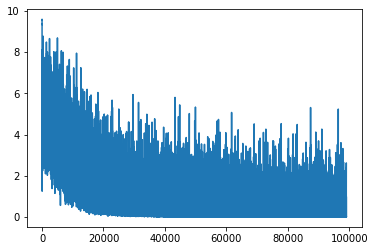

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(cost)

In [34]:
def translate(encoder_model, decoder_model, sentence, remove_spaces= False, toTensor=False):
    with torch.no_grad():
        sentence_translated = []
        encoder_hidden = encoder_model.init_hidden().to(device)
        
        all_encoder_outputs = torch.zeros(MAX_LEN_SENTENCE, encoder.hidden_size, device=device)
        for iw in range(sentence.size(0)):
            encoder_output, encoder_hidden = encoder_model(sentence[iw], encoder_hidden) 
            #stores all encoder outputs to be used on the decoder
            all_encoder_outputs[iw] = encoder_output[0, 0]
        
        decoder_hidden = encoder_hidden #the same hidden state is used for decoding
        decoder_input = torch.tensor([[SOS]], dtype=torch.long, device=device)
        for iw in range(MAX_LEN_SENTENCE):
            decoder_output, decoder_hidden, attn_weights = decoder_model(decoder_input, decoder_hidden, all_encoder_outputs)
            
            _, guess = decoder_output.topk(1)
            decoder_input = guess.squeeze().detach()
            
            if decoder_input.item() == EOS:
                break
            else:
                sentence_translated.append(target_language.index2word[decoder_input.item()])
                
        sentence_translated = ' '.join(sentence_translated) 
        if remove_spaces:
            sentence_translated = sentence_translated.replace(" ", "")
    return sentence_translated

In [35]:
def tensor2sentence(sentence, dictionary, remove_spaces=False):
    s = []
    for word in sentence:
        s.append(dictionary.index2word[word.item()])
        
    del s[-1] # remove EOS
    s = ' '.join(s)
    if remove_spaces:
        s = s.replace(" ", "")
    return s

In [36]:
print('Translation evaluation')
for idx, (inp_sentence, targ_sentence) in enumerate(train_loader):
    if idx >= 3:
        break
    
    inp_sentence = inp_sentence[0].to(torch.long).to(device)
    targ_sentence = targ_sentence[0].to(torch.long).to(device)
    
    print('input  :', tensor2sentence(inp_sentence, input_language))
    print('predict:', translate(encoder, decoder, inp_sentence, remove_spaces=True))
    print('output :', tensor2sentence(targ_sentence, target_language, remove_spaces=True))
    print('-----------------')
    

Translation evaluation
input  : they have already finished the work
predict: 彼らはもうその仕事を終えた
output : 彼らはもうその仕事を終えた
-----------------
input  : the storm didnt abate for several hours
predict: 嵐は数時間おさまらなかった
output : 嵐は数時間静まらなかった
-----------------
input  : thats right unfortunately
predict: 残念ながらその通りです
output : 残念ながらその通りです
-----------------
